In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(203)
import numpy as np
np.random.seed(345)
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path

# ANL 2025 Tutorial

## Developing a negotiator

The agents for the ANL competition are simple extensions of [NegMAS](https://yasserfarouk.github.io/negmas) negotiators. As such, they can be developed using any approach used to develop negotiators in NegMAS.

To develop a negotiator, you need to inherit from the [ANL2025Negotiator](http://www.yasserm.com/anl2025tmp/reference/#anl2025.negotiator.ANL2025Negotiator) class and implement the [`propose()`](http://www.yasserm.com/anl2025tmp/reference/#anl2025.negotiator.ANL2025Negotiator.propose) and [`respond()`](http://www.yasserm.com/anl2025tmp/reference/#anl2025.negotiator.ANL2025Negotiator.respond).

Here is a simple random negotiator:

In [8]:
from random import random
from negmas import Outcome, ResponseType, SAOState
from anl2025 import ANL2025Negotiator


class MyRandom2025(ANL2025Negotiator):
    p_end = 0.0003
    p_reject = 0.999

    def propose(
        self, negotiator_id: str, state: SAOState, dest: str | None = None
    ) -> Outcome | None:
        nmi = self.negotiators[negotiator_id].negotiator.nmi        
        return list(nmi.outcome_space.sample(1))[0]

    def respond(
        self, negotiator_id: str, state: SAOState, source: str | None = None
    ) -> ResponseType:        
        if random() < self.p_end:
            return ResponseType.END_NEGOTIATION

        if (
            random() < self.p_reject
            or float(self.ufun(state.current_offer)) < self.ufun.reserved_value  # type: ignore
        ):
            return ResponseType.REJECT_OFFER
        return ResponseType.ACCEPT_OFFER


### Testing the agent in a single session

The `anl2025` package provide two functions for running single multi-deal negotiation sessions:
1. `run_generated_session`  which runs a randomly generated session with some control over the types of negotiators for the center and edges as well as the utility functions used.
2. `run_session` which runs a session with some predefined `MultidealScenario`.

Both functions return a `SessionResults` object which allows you to access the following values after the session is completed:

1. `mechanisms` pointing to one [SAOMechanism](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOMechanism.html#saomechanism) for each negotiation thread.
2. `center_negotiator` pointing to a [ANL2025Negotiator](reference/#anl2025.negotiator.ANL2025Negotiator) for the center negotiator.
3. `edge_negotiators` pointing to a list of [SAONegotiators](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAONegotiator.html#saonegotiator) for the edge negotiators.
4. `center_utility` giving the utility value received by the center negotiator
5. `edge_utility` giving the utility value received by each edge negotiator.

Here is an example of running a session with our random negotiator against 3 edges on a randomly generated session.

Center Utility: 0.6879670245903828
Edge Utilities: [0.8239836532367947, 0.2199970863178983, 0.20403851233135215]

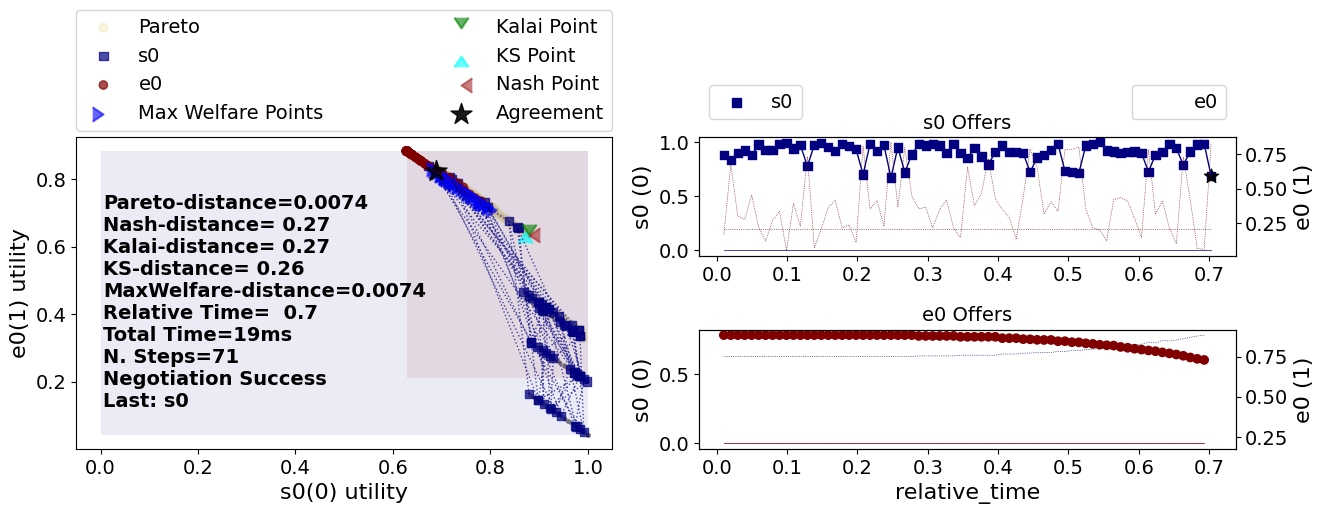

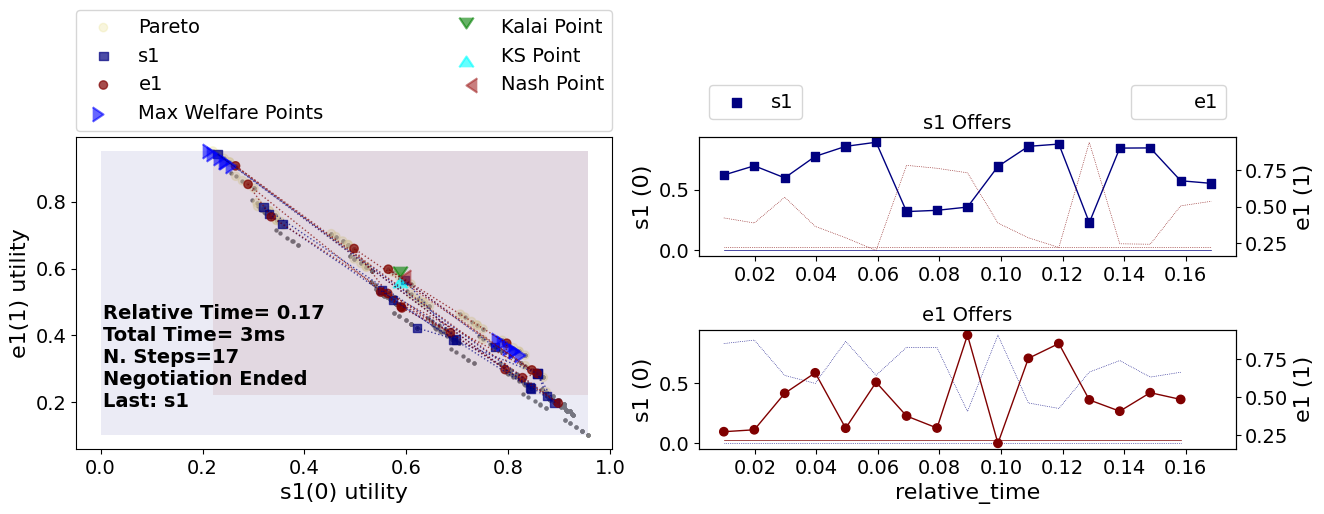

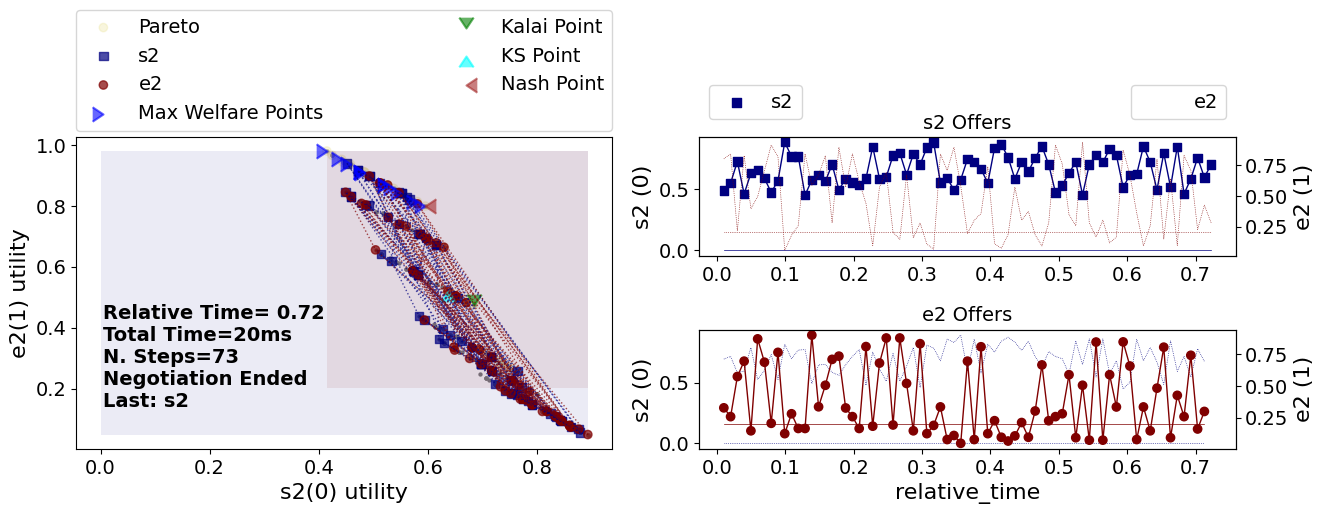

In [10]:
from anl2025 import run_generated_session
results = run_generated_session(center_type=MyRandom2025, nedges=3)
print(f"Center Utility: {results.center_utility}\nEdge Utilities: {results.edge_utilities}")

We can achieve the same result by first creating a scenario and then running the session:

Center Utility: 0.4118799345340276
Edge Utilities: [0.9549455705991858, 0.7660047417856862, 0.791918266076788]

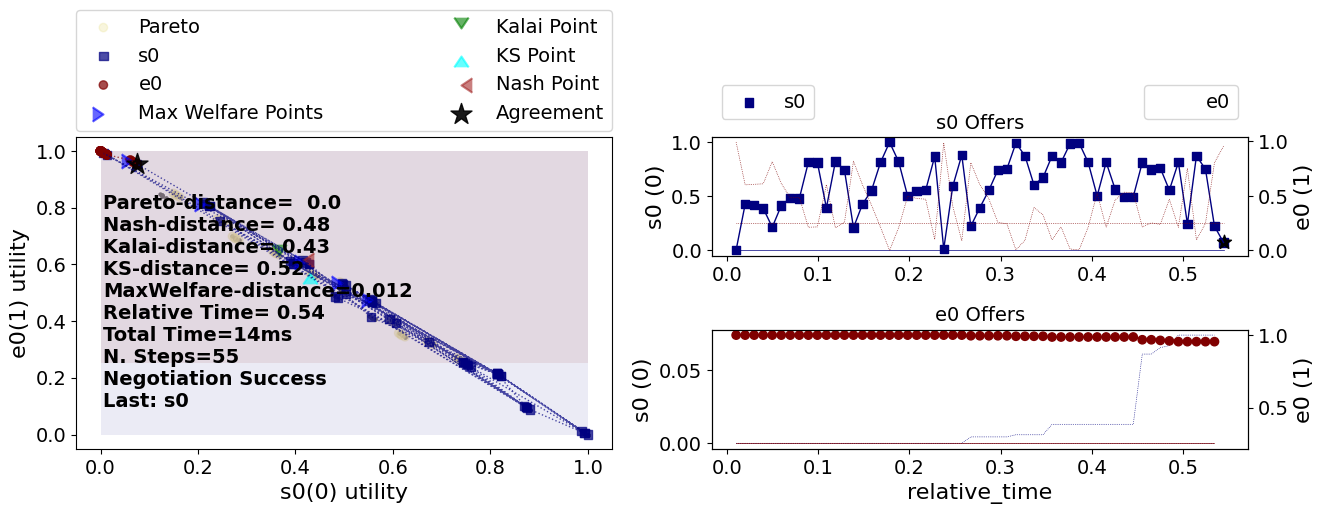

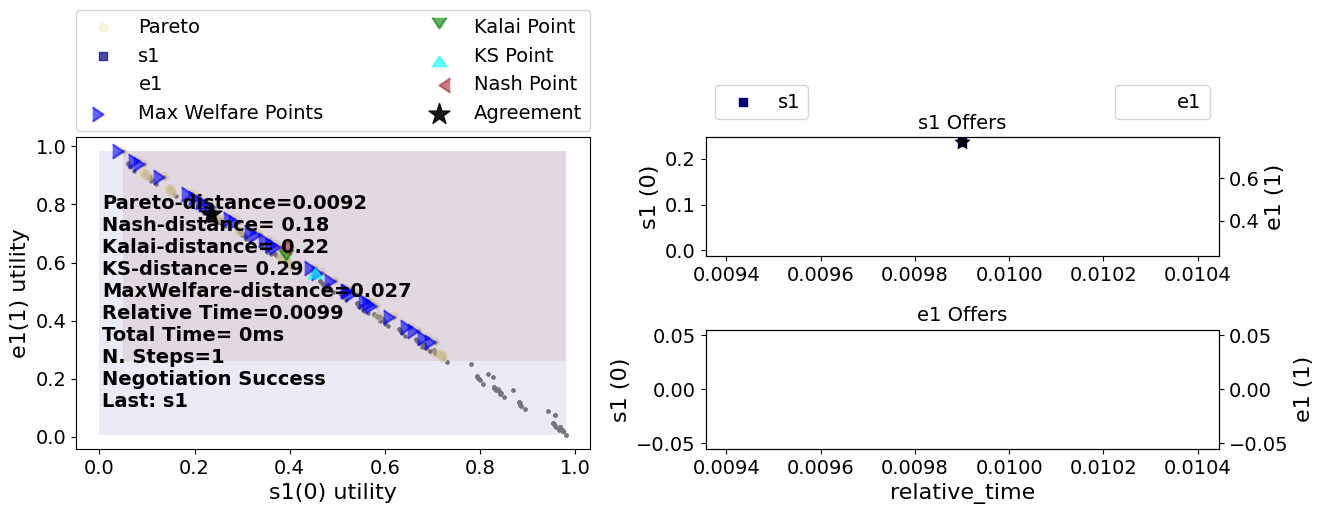

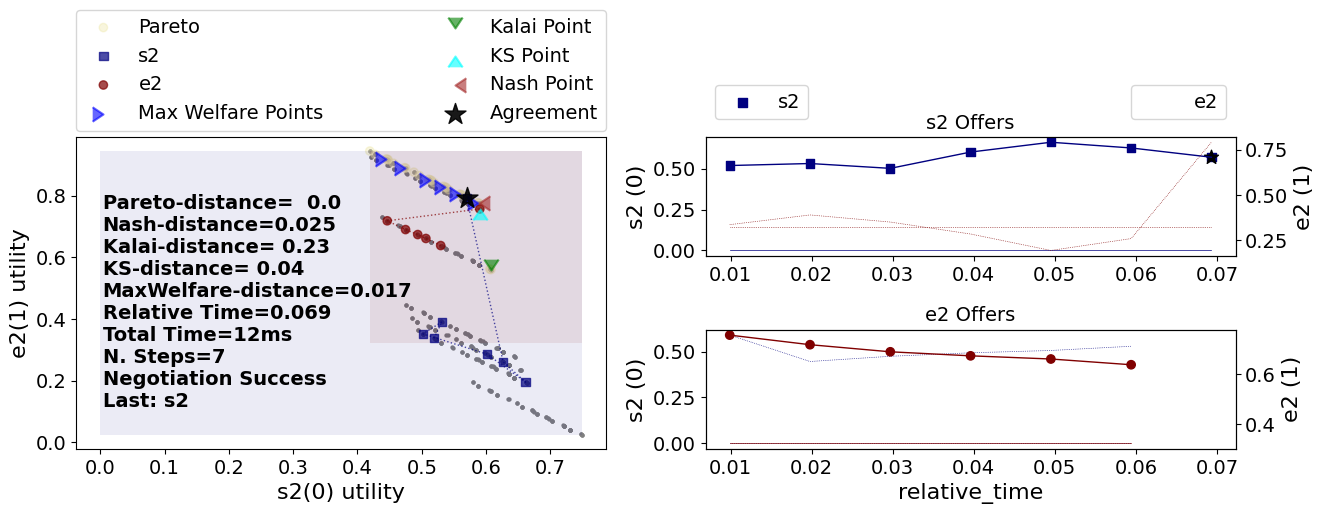

In [13]:
from anl2025 import make_multideal_scenario, run_session

scenario = make_multideal_scenario(nedges=3)
results = run_session(scenario, center_type=MyRandom2025)
print(f"Center Utility: {results.center_utility}\nEdge Utilities: {results.edge_utilities}")

### Testing the agent in a tournament

You can also run a complete tournament evaluating our agent against some other agents using `anl2025_tournament`:


In [15]:
from anl2025 import anl2025_tournament, Boulware2025, Linear2025

In [24]:
results = anl2025_tournament(
    scenarios=[make_multideal_scenario(nedges=3) for _ in range(2)],
    n_jobs=-1,
    competitors=(MyRandom2025, Boulware2025, Linear2025)
)

Output()

Output()

```note
Note that within a Jupyter notebook, you must pass n_jobs=-1 to run the whole tournament in the same process as the jupyter notebook itself. If this is not done, your class `MyRandom2025` will not  be found.
```

As expected, our random negotiator is worse than both builtin options.

We can get more information by analyzing the `scores` member which keeps track of individual scores of each negotiator in each sceanrio:

In [26]:
print(results.final_scores)

{'Boulware2025': 15.270375153939417, '__main__.MyRandom2025': 3.0136613454497363, 'Linear2025': 11.127208811206113}

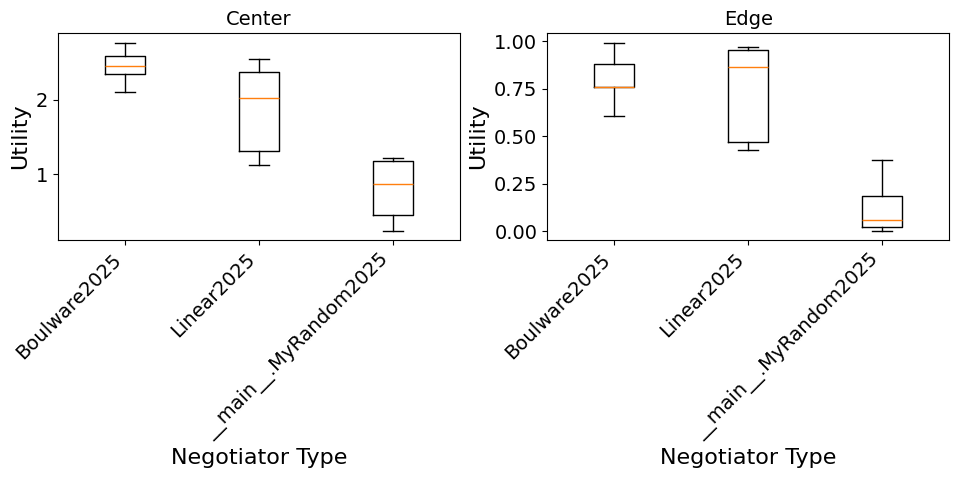

In [36]:
import pandas as pd
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
df = pd.DataFrame.from_records(results.scores)
# Filter data for the two cases (center and edge)
center_data = df[df['index'] == 0].groupby('agent')['utility'].apply(list).to_dict()
edge_data = df[df['index'] != 0].groupby('agent')['utility'].apply(list).to_dict()
ax1.boxplot(center_data.values())
ax1.set_xticklabels(center_data.keys())
ax1.set_xlabel('Negotiator Type')
ax1.set_ylabel('Utility')
ax1.set_title('Center')

# Box plot for index != 0
ax2.boxplot(edge_data.values())
ax2.set_xticklabels(edge_data.keys())
ax2.set_xlabel('Negotiator Type')
ax2.set_ylabel('Utility')
ax2.set_title('Edge')
# Rotate x-axis labels for both subplots
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

For this run, it is clear that the boulware negotiator is much better than the linear and our random negotiators when running in the center but (maybe) surprisingly, the linear agent is slightly better than the boulware agent when running as an edge.

```note
By default, scores as center are assigned `n. edges` times the weight of scores as edges because the agent runs almost this number of times as an edge for each time it runs as a center. This weight can be controlled using the `center_multiplier` and the `edge_multiplier`. The organization committee of ANL 2025 keeps the right to change these weights in the finals.
```



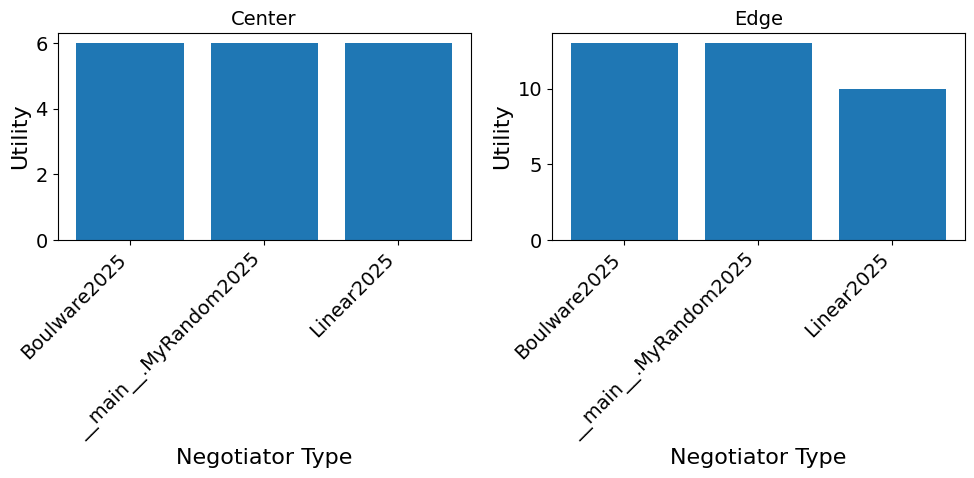

In [42]:
import pandas as pd
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
df = pd.DataFrame.from_records(results.scores)
# Filter data for the two cases (center and edge)
center_data = df[df['index'] == 0]['agent'].value_counts().to_dict()
edge_data = df[df['index'] != 0]['agent'].value_counts().to_dict()
ax1.bar(center_data.keys(), center_data.values())
ax1.set_xlabel('Negotiator Type')
ax1.set_ylabel('Utility')
ax1.set_title('Center')

# Box plot for index != 0
ax2.bar(edge_data.keys(), edge_data.values())
ax2.set_xlabel('Negotiator Type')
ax2.set_ylabel('Utility')
ax2.set_title('Edge')
# Rotate x-axis labels for both subplots
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Types of multideal scenarios in ANL 2025




## Available helpers

Our negotiator was not so good but it exemplifies the simplest method for developing a negotiator for ANL 2025. For more information refer to [NegMAS Documentation](https://negmas.readthedocs.io). You develop your agent, as explained above, by implementing the `propose()` and `respond()` methods of your class.

Under the hood, every `ANL2025Negotiator` is an [SAOController](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOController.html) which is the class ressponsible for handling multiple negotiations at once in NegMAS for the Stacked Alternating Offers Protocol. An `SAOController` is a subclass of  [Controller](https://negmas.readthedocs.io/en/latest/api/negmas.negotiators.Controller.html) which is responsible of handing multiple negotiations for any protocol in [NegMAS](https://negmas.readthedocs.io).

You can use any of the properties and methods provided by these classes in your development. The following sections describe some of the most important

### Parameters of propose and respond
Whenever your negotiator is called by the protocol, it receives the `negotiator_id` which is a unique ID for each negotiation thread and the `state` of this negotiation (an [SAOState](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOState.html#saostate)).

### The acceptancd  strategy (response)

### The bidding (offering) strategy (propose)
This method, receives an [SAOState](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOState.html) which represents the current `state` of the negotiation. The most important members of this state object are `current_offer` which gives the current offer from the partner (or `None` if this is the beginning of the negotiation) and `relative_time` which gives the relative time of the negotiation ranging between `0` and `1`.

It should return an [SAOResponse](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOResponse.html) represeting the agent's `response` which consists of two parts:

1. A [ResponseType](https://negmas.readthedocs.io/en/latest/api/negmas.gb.ResponseType.html) with the following allowed values:
    - `ResponseType.ACCEPT_OFFER`, accepts the current offer (pass the current offer as the second member of the response).
    - `ResponseType.REJECT_OFFER`, rejects the current offer (pass you counter-offer as the second member of the response).
    - `ResponseType.END_NEGOTIATION`, ends the negotiation immediately (pass `None` as the second member of the response).
2. A counter offer (in case of rejection), the received offer (in case of acceptance) or `None` if ending the negotiation.


### Properties available from the undelying Controller


### Properties and methods available through the NMI

The negotiator can use the following objects to help it implement its strategy:

- `self.nmi` A [SAONMI](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAONMI.html) that gives you access to all the settings of this negotiation and provide some simple helpers:
    - `n_steps`, `time_limit` The number of rounds and seconds allowed for this negotiation (`None` means no limit).
    - `random_outcomes(n)` Samples `n` random outcomes from this negotiation.
    - `outcome_space` The [OutcomeSpace](https://negmas.readthedocs.io/en/latest/api/negmas.outcomes.OutcomeSpace.html) of the negotiation which represent all possible agreements. In ANL 2024, this will always be of type [DiscreteCartesianOutcomeSpace](https://negmas.readthedocs.io/en/latest/api/negmas.outcomes.DiscreteCartesianOutcomeSpace.html) with a single issue.
    - `discrete_outcomes()` A generator of all outcomes in the outcome space.
    - `log_info()` Logs structured information for this negotiator that can be checked in the logs later (Similarily there are `log_error`, `log_warning`, `log_debug`).

### Tools available through the utility function

- `self.ufun` A [LinearAdditiveUtilityFunction](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.LinearAdditiveUtilityFunction.html#negmas.preferences.LinearAdditiveUtilityFunction) representing the agent's own utility function. This object provides some helpful functionality including:
   - `self.ufun.is_better(a, b)` Tests if outcome `a` is better than `b` (use `None` for disagreement). Similarily we have, `is_worse`, `is_not_worse` and `is_not_better`.
   - `self.ufun.reserved_value` Your negotiator's reserved/reservation value (between 0 and 1). You can access this also as `self.ufun(None)`.
   - `self.ufun(w)` Returns the utility value of the outcome `w`. It is recommended to cast this value to float (i.e. `float(self.ufun(w)`) to support probabilistic utility functions.
   - `self.outcome_space` The [OutcomeSpace](https://negmas.readthedocs.io/en/latest/api/negmas.outcomes.OutcomeSpace.html) of the negotiation which represent all possible agreements. In ANL 2024, this will always be of type [DiscreteCartesianOutcomeSpace](https://negmas.readthedocs.io/en/latest/api/negmas.outcomes.DiscreteCartesianOutcomeSpace.html) with a single issue.
   - `self.ufun.invert()` Returns and caches an [InverseUtilityFunction](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.InverseUFun.html#negmas.preferences.InverseUFun) object which can be used to find outcomes given their utilities. The most important services provided by the InverseUtilityFunction returned are:
       - `minmax()` returns the minimum and maximum values of the ufun (will always be (0, 1) approximately in ANL 2024).
       - `best()`, `worst()` returns the best (worst) outcomes.
       - `one_in()`, `some_in()` returns one (or some) outcomes within the given range of utilities.
       - `next_better()`, `next_worse()` returns the next outcome descendingly (ascendingly) in utility value.
- `self.opponent_ufun` A [LinearAdditiveUtilityFunction](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.LinearAdditiveUtilityFunction.html#negmas.preferences.LinearAdditiveUtilityFunction) representing the **opponent's** utility function. You can access this also as `self.private_info["opponent_ufun"]`. This utility function will have a zero reserved value independent of the opponent's true reserved value. You can actually set the reserved value on this object to your best estimate. All ufun funcationality is available in this object.


Other than these objects, your negotiator can access any of the analytic facilities available in NegMAS. For example, you can calculate the [pareto_frontier](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.pareto_frontier.html), [Nash Bargaining Soluion](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.nash_points.html), [Kalai Bargaining Solution](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.kalai_points.html), [points with maximum wellfare](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.max_welfare_points.html), etc. You can check the implementation of the [NashSeeker](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/nash_seeker.py) agent for examples of using these facilities.


## Other Callbacks

Other than implementing the `propose()` and `respond()` methods, you can optionally implement one or more of the following callbacks to initialize your agent:

- `init()` This is called after all the negotiation threads are initialized but before any of them are started. You can use it to initialize your agent while having access to all the tools described above
  
- `on_negotiation_start(state: SAOState)` This [callback](https://negmas.readthedocs.io/en/latest/api/negmas.negotiators.EvaluatorNegotiator.html#negmas.negotiators.EvaluatorNegotiator.on_negotiation_start) is called once per negotiation after the ufuns are set but before any offers are exchanged.
- `on_preferences_changed(changes)` This [callback](https://negmas.readthedocs.io/en/latest/api/negmas.negotiators.EvaluatorNegotiator.html#negmas.negotiators.EvaluatorNegotiator.on_preferences_changed) is called **whenever** your negotiator's ufun is changed. This will happen at the beginning of each negotiation but it can also happen again if the ufun is changed **while the negotiation is running**. In ANL 2024, ufuns never change during the negotiation so this callback is equivalent to `on_negotiation_start()` but for future proofness, you should use this callback for any initialization instead to guarantee that this initialization will be re-run in cases of changing utility function.

## Understanding our random negotiator

Now we can analyze the simple random negotiator we developed earlier.

- Firstly, we find the current offer that we need to respond to:
  ```python
  offer = state.current_offer
  ```
- **Acceptance Strategy** We then accept this offer if three conditions are satisfied:
  - The offer is not `None` which means that we are not starting the negotiation just now:
  - The offer is not worse than disagreement. This prevents us from accepting irrational outcomes.
  - A random number we generated is less than 0.25. This means we accept rational offers with probability 25%.
    ```python
    if offer is not None and self.ufun.is_not_worse(offer, None) and random.random() < 0.25:
        return SAOResponse(ResponseType.ACCEPT_OFFER, offer)
    ```
- **Offering Strategy** If we decided not to accept the offer, we simply generate a single random outcome and offer it:
  ```python
  return SAOResponse(ResponseType.REJECT_OFFER, self.nmi.random_outcomes(1)[0])
  ```

This negotiator did not use the fact that we know the opponent utility function up to reserved value. It did not even use the fact that we know our *own* utility function. As expected, it did not get a good score. Let's develop a simple yet more meaningful agent that uses both of these pieces of information.

Can you now see why is this negotiator is getting negative advantages sometimes? We were careful in our acceptance strategy but not in our *offering strategy*. There is nothing in our code that prevents our negotiator from offering irrational outcomes (i.e. outcomes worse than disagreement for itself) and sometimes the opponent will just accept those. Can you fix this?

## A more meaningful negotiator

How can we use knowledge of our own and our opponent's utility functions (up to reserved value for them)? Here is one possibility:

- **Acceptance Strategy** We accept offers that have a utility above some *aspiration* level. This aspiration level starts very high (1.0) and goes monotoncially down but never under the reserved value which is reached when the relative time is 1.0 (i.e. by the end of the negotiation). This is implemented in `is_acceptable()` below.
- **Opponent Modeling** We estimate the opponent reserved value under the assumption that they are using a monotonically decreasing curve to select a utility value and offer an outcome around it. This is implemented in `update_reserved_value()` below.

- **Bidding Strategy** Once we have an estimate of their reserved value, we can then find out all outcomes that are rational for both we and them. We can then check the relative time of the negotiation and offer outcomes by conceding over this list of rational outcomes. This is implemented in the `generate_offer()` method below.

In [10]:
anl2024_tournament(
    n_scenarios=1, n_repetitions=3, nologs=True, njobs=-1,
    competitors=[MyRandom2025, SimpleRVFitter, Boulware, Conceder]
).final_scores

Will run 48 negotiations on 1 scenarios between 4 competitors

Output()

strategy     score
0            Boulware  0.648516
1      SimpleRVFitter  0.562182
2            Conceder  0.314239
3  MyRandom2025  0.040486

,strategy,score
0,Boulware,0.648516
1,SimpleRVFitter,0.562182
2,Conceder,0.314239
3,MyRandom2025,0.040486


Much better :-)

Let's see how each part of this negotiator works and how they fit together.

### Construction
The first method of the negotiator to be called is the `__init__` method which is called when the negotiator is created **usually before the ufun is set**. You can use this method to construct the negotiator setting initial values for any variables you need to run your agent.

An important thing to note here is that your negotiator **must** pass any parameters it does not use to its parent to make sure the object is constructed correctly. This is how we implement this in our `SimpleRVFitter`:

```python
def __init__(self, *args, e: float = 5.0, **kwargs):
    super().__init__(*args, **kwargs)
```

We then set the variables we need for our negotiator:

- `self.e` stores the exponent of the concession curve we will be use (more on that later).
- `self.opponent_times`, `self.opponent_utilities` keep track of the times the opponent offers and its own utility of its offers. We will use that to estimate the opponent's reserved value using simple curve fitting in `update_reserved_values()`.
- `self._past_oppnent_rv = 0.0` We start assuming that the opponent has zero reserved value. This is an optimistic assumption because it means that anything rational for us is rational for the opponent so we have more negotiation power.
- `self._rational` This is where we will store the list of rational outcomes to concede over. For each outcome we will store our utility, opponent utility and the outcome itself (in that order).

### Overall Algorithm

The overall algorithm is implemented --- as usual --- in the `__call__()` method. This is the complete algorithm:

```python
def __call__(self, state):
    self.update_reserved_value(state.current_offer, state.relative_time)
    if self.is_acceptable(state.current_offer, state.relative_time):
        return SAOResponse(ResponseType.ACCEPT_OFFER, state.current_offer)
    return SAOResponse(ResponseType.REJECT_OFFER, self.generate_offer(state.relative_time))
```

We start by updating our estimate of the reserved value of the opponent using `update_reserved_value()`. We then call the acceptance strategy `is_acceptable()` to check whether the current offer should be accepted. If the current offer is not acceptable, we call the bidding strategy `generate_offer()` to generate a new offer which we return as our counter-offer. Simple!!

### Opponent Modeling (Estimating Reserved Value)

The first step is in our algorithm is to update our estimate of the opponent's reserved value. This is done in three simple steps:

1. If we have not offer from the opponent, there is nothing to do. Just return:
   ```python
   if offer is None:
        return
   ```
2. We append the time and opponent's utility to our running list of opponent offer utilities:
   ```python
   self.opponent_utilities.append(float(self.opponent_ufun(offer)))
   self.opponent_times.append(relative_time)
   ```
3. We apply a simple [curve fitting](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) algorithm from [scipy](https://scipy.org) to estimate the opponent's reserved value (and its concession exponent but we are not going to use that):

      - We set the bounds of the reserved value to be between zero (minimum possible value) and the minimum utility the opponent ever offered. This assumes that the opponent only offers rational outcomes for itself. The bounds for the concession curve are set to (0.2, 5.0) which is the usual range of exponents used by time-based strategies.
      ```python
      bounds = ((0.2, 0.0), (5.0, min(self.opponent_utilities)))
      ```
      - We then just apply curve fitting while keeping the old estimate. We keep the old estimate to check whether there is enough change to warrent reevaluation of the rational outcome sets in our offering strategy. We ignore any errors keeping the old estimate in that case.

      ```python
      optimal_vals, _ = curve_fit(
          lambda x, e, rv: aspiration_function(x, self.opponent_utilities[0], rv, e),
          self.opponent_times, self.opponent_utilities, bounds=bounds
      )

      ```
      Note that we just pass `self.opponent_utilities[0]` as the maximum for the concession curve because we know that this is the utility of the first offer from the opponent.

      - Finally, we update the opponent reserved value with our new estimate keeping the latest value for later:
      ```python
      self._past_oppnent_rv = self.opponent_ufun.reserved_value
      self.opponent_ufun.reserved_value = optimal_vals[1]
      ```

### Acceptance Strategy

Our acceptance strategy is implemented in `is_acceptable()` and consists of the following steps:

1. Reject if no offer is found (i.e. we are starting the negotiation now):
   ```python
   if offer is None:
       return False
   ```
2. Find our current aspiration level which starts at 1.0 (inidicating we will only accept our best offer in the first step) ending at our reserved value (indicating that we are willing to accept any rational outcome by the end of the negotiation). Use the exponent we stored during construction.
   ```python
   asp = aspiration_function(state.relative_time, 1.0, self.ufun.reserved_value, self.e)
   ```
3. Accept the offer iff its utility is higher than the aspiration level:
    ```python
    return float(self.ufun(offer)) >= asp
    ```
Note that this acceptance strategy does not use the estimated opponent reserved value (or the opponent's ufun) in any way.

### Bidding Strategy

Now that we have updated our estimate of the opponent reserved value and decided not to accept their offer, we have to generate our own offer which the job of the bidding strategy implementedin `generate_offer()`. This is done in three steps as well:

1. If the difference between the current and last estimate of the opponent reserved value is large enough, we create the rational outcome list.
    - This test is implemented by:
    ```python
    not self._rational or abs(self.opponent_ufun.reserved_value - self._past_oppnent_rv) > 1e-3
    ```
    - We then create of all outcomes prepending them with our and opponent's utility values:
  ```python
  [ (my_util, opp_util, _)
    for _ in self.nmi.outcome_space.enumerate_or_sample(
        levels=10, max_cardinality=100_000
    )
    if (
        (my_util := float(self.ufun(_))) > self.ufun.reserved_value
        and (opp_util := float(self.opponent_ufun(_))) > self.opponent_ufun.reserved_value
  )]
  ```
    - Finally, we sort this list. Because each element is a tuple, the list will be sorted ascendingly by our utility with equal values sorted ascendingly by the opponent utility.
  ```python
  self._rational = sorted(...)
  ```

2. If there are no rational outcomes (e.g. our estimate of the opponent rv is very wrong), then just revert to offering our top offer
   ```python
   if not self._rational:
        return self.ufun.best()
   ```
3. If we have a rational set, we calculate an aspiration level that starts at 1 and ends at 0 (note that we do not need to end at the reserved value because all outcomes in `self._rational` are already no worse than disagreement. We then calculate the outcome that is at the current aspiration level from the end of the rational outcome list and offer it:
   ```python
   asp = aspiration_function(relative_time, 1.0, 0.0, self.e)
   max_rational = len(self._rational) - 1
   indx = max(0, min(max_rational, int(asp * max_rational)))
   outcome = self._rational[indx][-1]
   return outcome
   ```

### Running a single negotiation

What if we now want to see what happens in a single negotiation using our shiny new negotiator?
We first need a scenario to define the outcome space and ufuns. We can then add negotiators to it and run it. Let's see an example:

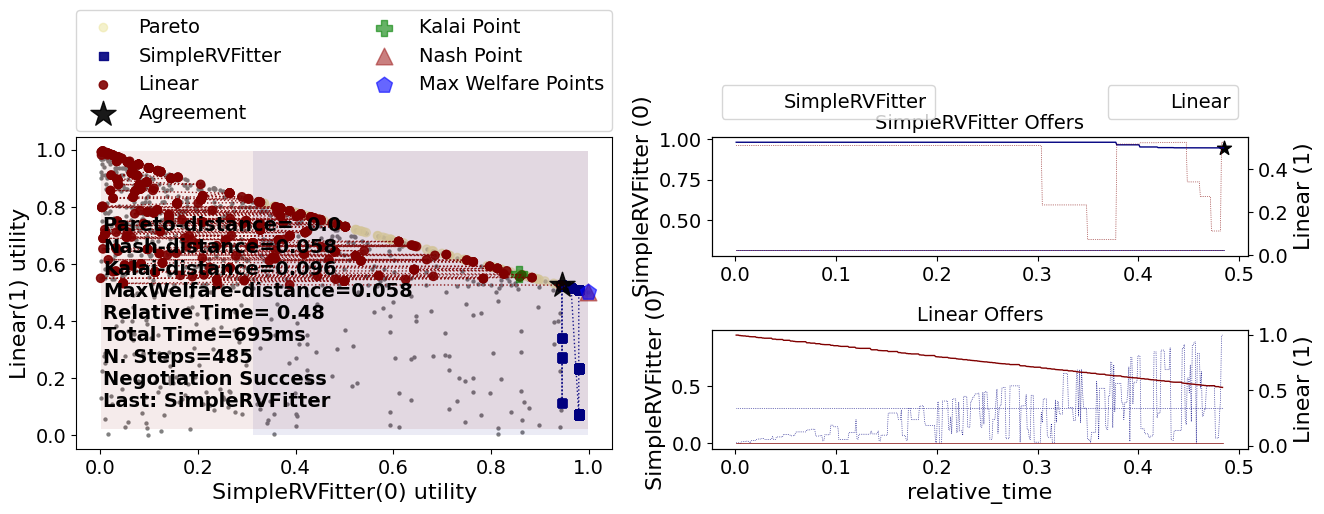

In [11]:
import copy
from negmas.sao import SAOMechanism
from anl.anl2024.runner import mixed_scenarios
from anl.anl2024.negotiators.builtins import Linear

# create a scenario
s = mixed_scenarios(1)[0]
# copy ufuns and set rv to 0 in the copies
ufuns0 = [copy.deepcopy(u) for u in s.ufuns]
for u in ufuns0:
    u.reserved_value = 0.0
# create the negotiation mechanism
session = SAOMechanism(n_steps=1000, outcome_space=s.outcome_space)
# add negotiators. Remember to pass the opponent_ufun in private_info
session.add(
    SimpleRVFitter(name="SimpleRVFitter",
                   private_info=dict(opponent_ufun=ufuns0[1]))
    , ufun=s.ufuns[0]
)
session.add(Linear(name="Linear"), ufun=s.ufuns[1])
# run the negotiation and plot the results
session.run()
session.plot()
plt.show()

Notice how in the second half of the negotiation, the SimpleRVFitter is only offering outcomes that are rational for both negotiators (can you see that in the left-side plot? can you see it in the top right-side plot?). This means that the curve fitting approach is working OK here. The opponent is a time-based strategy in this case though.

What happens if it was not? Let's try it against the builtin RVFitter for example

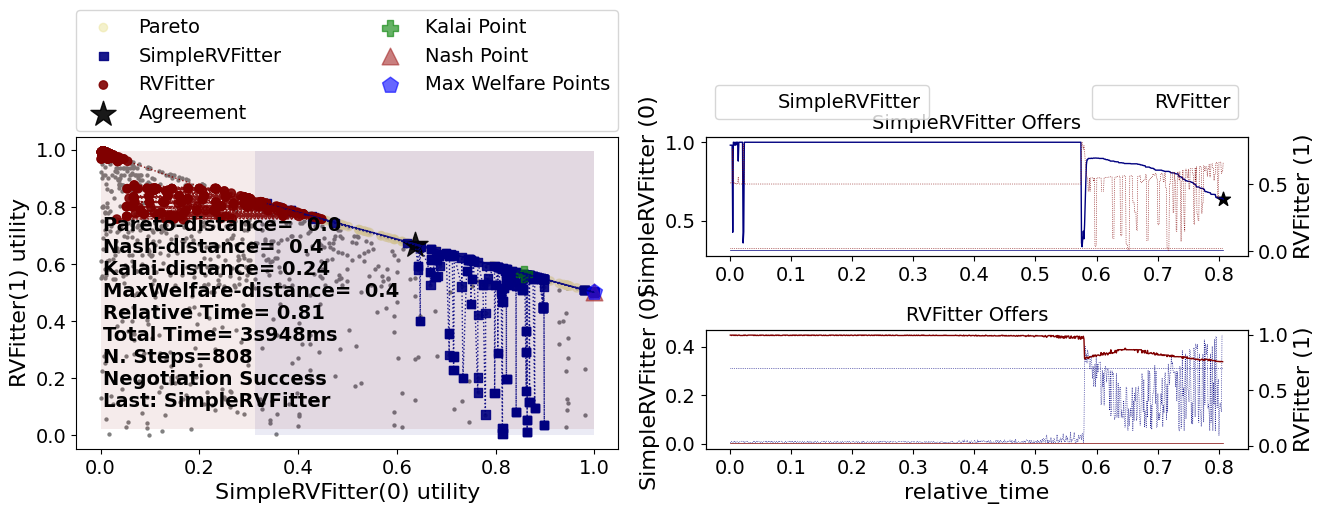

In [12]:
from anl.anl2024.negotiators import RVFitter
# create the negotiation mechanism
session = SAOMechanism(n_steps=1000, outcome_space=s.outcome_space)
# add negotiators. Remember to pass the opponent_ufun in private_info
session.add(
    SimpleRVFitter(name="SimpleRVFitter",
                   private_info=dict(opponent_ufun=ufuns0[1]))
    , ufun=s.ufuns[0]
)
session.add(
    RVFitter(name="RVFitter",
                   private_info=dict(opponent_ufun=ufuns0[0]))
    , ufun=s.ufuns[1]
)

# run the negotiation and plot the results
session.run()
session.plot()
plt.show()

This time, our simple RV fitter could not really learn the opponent reserved value effectively. We can see that from the fact that it kept offering outcomes that are irrational for the opponent almost until the end of the negotiation.

The builtin `RVFitter` seems better in this case. It took longer but it seems to only offer rational outcomes for its opponent (our SimpleRVFitter) after around 60% of the available negotiation time.

## Other Examples

The ANL package comes with some example negotiators. These are not designed to be stong but to showcase how to use some of the features provided by the platform.

- [MiCRO](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/micro.py) A strong baseline behavioral negotiation strategy developed by de Jonge, Dave in "An Analysis of the Linear Bilateral ANAC Domains Using the MiCRO Benchmark Strategy.", ICJAI 2022. This strategy assumes no knowledge of the opponent utility function and is implemented from scratch to showcase the following:
    - Using `on_preferences_changed` for initialization.
    - Using [PresortingInverseUtilityFunction](https://negmas.readthedocs.io/en/latest/api/negmas.preferences.PresortingInverseUtilityFunction.html) for inverting a utility function.
- [NashSeeker](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/nash_seeker.py) A naive strategy that simply sets the opponent reserved value to a fixed value and then uses helpers from NegMAS to find the [Nash Bargaining Solution](https://en.wikipedia.org/wiki/Cooperative_bargaining) and use it for deciding what to offer. This showcases:
    - Using NegMAS helpers to calculate the pareto-frontier and the Nash Bargaining Solution
- [RVFitter](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/rv_fitter.py) A strategy very similar to the one we implemented earlier as `SimpleRVFitter`. Instead of trying to estiamte the opponent reserved value from the first step, this strategy waits until it collects few offers before attempting the etimation. This showcases:
    - Setting the opponent reserved value based on our best estimate.
    - A simple way to use this estimate for our bidding strategy.
    - Using **logging**. Logs can be saved using `self.nmi.log_info(dict(my_key=my_value))` and found under the logs folder.
- [Boulware, Conceder, Linear](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/wrappers.py) Time-based strategies that are implemented by just setting construction parameters of an existing NegMAS negotiator
- [StochasticBoulware, StochasticConceder, StochasticLinear](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/wrappers.py) Stochastic versions of the three time-based strategies above implemented by just setting construction parameters of an existing NegMAS negotiator
- [NaiveTitForTat](https://github.com/yasserfarouk/anl/blob/main/src/anl/anl2024/negotiators/builtins/wrappers.py) A simple behavioral strategy implemented by just inheriting from an existing NegMAS negotiator.

#### Note about running tournaments

- When running a tournament using `anl2024_tournament` inside a Jupyter Notebook, you **must** pass `njobs=-1` to force serial execution of negotiations. This is required because the multiprocessing library used by NegMAS does not play nicely with Jupyter Notebooks. If you run the tournament using the same method from a `.py` python script file, you can omit this argument to run a tournament using all available cores.
- When you pass `nologs=True`, no logs are stored for this tournament. If you omit this argument, a log will be created under `~/negmas/anl2024/tournaments` which can be visualized using the ANL visualizer by running:

```bash
anlv show
```
